UAVid dataset: https://uavid.nl/

Steps:
 - Install Pytorch via Pip/Conda https://pytorch.org/get-started/locally/
 - Download dataset via link: https://disk.yandex.ru/d/Mw39uGBey44azw
 - Extract dataset zip archive
 - Change `DATASET_DIR` accordingly
 - Implement `UAVIDDataset`.
 - Run the whole notebook to assess SegNet of `UAVIDSemanticSegmentationModel`
 - Modify code of `UAVIDSemanticSegmentationModel` to boost semantic segmentation quality quality of test images. You can choose UNet, PSPnet, DeepLab or something else.

In [1]:
import os
import cv2
import numpy as np
import ipywidgets
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

In [2]:
class UAVIDDataset(Dataset):
    def __init__(self, dataset_dir: str, image_height: int, image_width: int, train: bool = False):
        super(UAVIDDataset, self).__init__()
        self.dataset_dir = dataset_dir
        self.image_height = image_height
        self.image_width = image_width
        self.train = train
        
        dir_suffix = 'train' if self.train else 'test'
        label_name = 'TsignRecgTrain4170Annotation.txt' if self.train else 'TsignRecgTest1994Annotation.txt'
        
        self.image_dir = f'{self.dataset_dir}/images_{dir_suffix}/'
        self.label_path = f'{self.dataset_dir}/annotations_{dir_suffix}/{label_name}'

        self.image_names, self.x1y1x2y2s, self.labels = self._load_labels(self.label_path)
        
        self.transform = transforms.Compose(
            [ 
                transforms.ToTensor(),
                transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
            ]
        )
    def __getitem__(self, index):
        image = self.get_np_image(index)
        image = np.array(image / 255, dtype=np.float32)
        image = self.transform(image)
        label = self.labels[index]
        return image, label
        
    def get_np_image(self, index):
        image = cv2.imread(f'{self.image_dir}/{self.image_names[index]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x1, y1, x2, y2 = self.x1y1x2y2s[index]
        image = image[y1: y2, x1: x2, ...]
        image = cv2.resize(image, (self.image_width, self.image_height), interpolation=cv2.INTER_CUBIC)
        return image
    
    def get_np_label(self, index):
        with open(path, 'r') as f:
            labels = f.readlines()
        labels = [label.strip().split(';') for label in labels]
        image_names = [label[0] for label in labels]
        x1y1x2y2s = [(int(label[3]), int(label[4]), int(label[5]), int(label[6])) for label in labels]
        labels = [int(label[-2]) for label in labels]
        return image_names, x1y1x2y2s, labels
    
    def __len__(self):
        return len(self.image_names)
    
    
def create_dataloader(dataset: Dataset, batch_size: int, num_workers: int, train: bool = False):
    return DataLoader(
        dataset=dataset, batch_size=batch_size, 
        shuffle=train, num_workers=num_workers,
        pin_memory=True, drop_last=False)

# Metric

In [3]:
class IOU(nn.Module):
    def __init__(self, eps=1.0, activation=None):
        super().__init__()
        self.eps = eps
        if activation is None:
            self.activation = torch.sigmoid
        else:
            self.activation = activation

    def forward(self, y_pr, y_gt):
        if self.activation is not None:
            y_pr = self.activation(y_pr)
        y_pr = y_pr > 0.5
        y_gt = gt_to_stacked(y_pr, y_gt)
        return get_iou(y_pr, y_gt, eps=self.eps)

    
def gt_to_stacked(pred, gt):
    stacked = torch.zeros_like(pred)
    for i in range(pred.shape[1]):
        stacked[:, i, ...] = gt == i
    return stacked
    
    
def get_iou(pr, gt, eps=1e-6):    
    ious = list()
    
    for i in range(pr.shape[1]):
        gt_i = gt[:, i, ...]
        pr_i = pr[:, i, ...]
        intersection = torch.sum(gt_i * pr_i)
        union = torch.sum(gt_i) + torch.sum(pr_i) - intersection + eps
        iou_i = (intersection + eps) / union
        ious.append(iou_i)
    
    return sum(ious) / len(ious)

# Loss

In [4]:
class Loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, outputs, labels):
        return self.criterion(outputs, labels)

# Utils

In [5]:
def evaluate(model: nn.Module, dataloader: DataLoader, train: bool = False):
    model.eval()
    
    iou_list = list()
    iou_metric = IOU()
    
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            current_iou = iou_metric(outputs, labels).item()
            iou_list.append(current_iou)

    images = len(dataloader) * dataloader.batch_size
    prefix = "train" if train else "test"
    print(f'mIOU of the network on the {images} {prefix} images: {(sum(iou_list) / len(iou_list)):.3f} %')
    

def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(
        nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(num_rows * 16, num_cols * 16))

    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Model

In [6]:
class Conv2DBatchNormRelu(nn.Module):
    def __init__(
        self,
        in_channels,
        n_filters,
        k_size,
        stride,
        padding,
        bias=True,
        dilation=1,
        is_batchnorm=True,
    ):
        super(Conv2DBatchNormRelu, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=(dilation, dilation)
        )

        if is_batchnorm:
            self.cbr_unit = nn.Sequential(
                conv_mod, nn.BatchNorm2d(int(n_filters)), nn.ReLU(inplace=True)
            )
        else:
            self.cbr_unit = nn.Sequential(conv_mod, nn.ReLU(inplace=True))

    def forward(self, inputs):
        outputs = self.cbr_unit(inputs)
        return outputs


class SegNetDown2(nn.Module):
    def __init__(self, in_size, out_size):
        super(SegNetDown2, self).__init__()
        self.conv1 = Conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = Conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class SegNetUp2(nn.Module):
    def __init__(self, in_size, out_size):
        super(SegNetUp2, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = Conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = Conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class SegNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, is_unpooling=True):
        super(SegNet, self).__init__()
        self.in_channels = in_channels
        self.is_unpooling = is_unpooling

        self.down1 = SegNetDown2(self.in_channels, 128)
        self.down2 = SegNetDown2(128, 256)

        self.up2 = SegNetUp2(256, 128)
        self.up1 = SegNetUp2(128, 64)

        self.classification = nn.Conv2d(64, num_classes, kernel_size=(3, 3), padding=1)

    def forward(self, inputs):
        down1, indices_1, unpool_shape1 = self.down1(inputs)
        down2, indices_2, unpool_shape2 = self.down2(down1)
        up2 = self.up2(down2, indices_2, unpool_shape2)
        up1 = self.up1(up2, indices_1, unpool_shape1)
        semantic = self.classification(up1)
        return semantic
    
    
class UAVIDSemanticSegmentationModel(nn.Module):
    def __init__(self, num_classes: int):
        super(UAVIDSemanticSegmentationModel, self).__init__()
        self.model = SegNet(num_classes=num_classes)

    def forward(self, x):
        y = self.model(x)
        return y

# Parameters

In [7]:
DATASET_DIR = '/home/sawseen/data/education/datasets/uavid'

NUM_CLASSES = 8

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

BATCH_SIZE = 8
NUM_WORKERS = 8
EPOCHS = 8

CHECKPOINT_PATH = f'./uavid_semantic_segmentation_model_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.pth'

# Datasets

In [8]:
train_dataset = UAVIDDataset(
    dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH, train=True)

val_dataset = UAVIDDataset(
    dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH)

train_dataloader = create_dataloader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, train=True)

val_dataloader = create_dataloader(
    val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Data examples

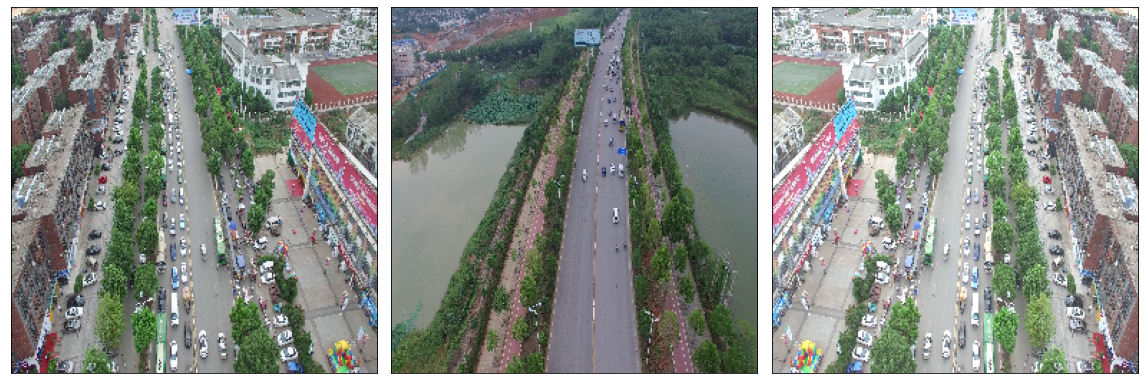

In [9]:
indices = [0, 100, 200]
plot([train_dataset.get_np_image(index) for index in indices]);

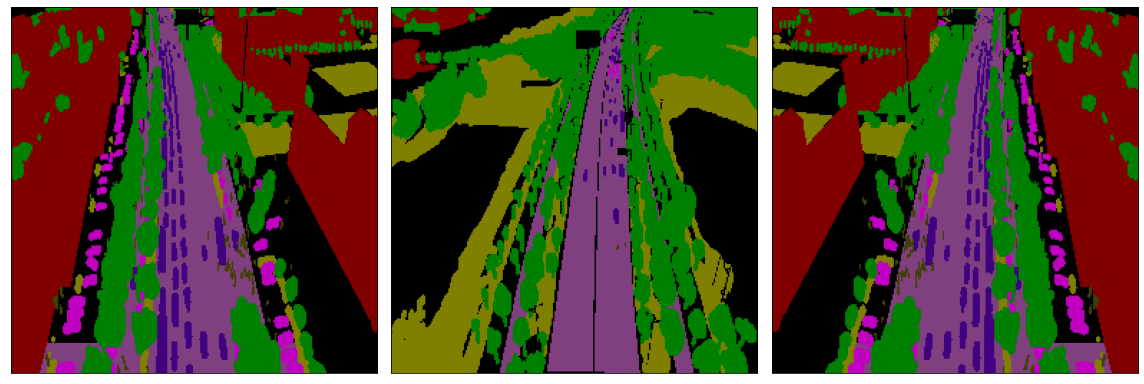

In [10]:
indices = [0, 100, 200]
plot([train_dataset.get_np_label(index) for index in indices]);

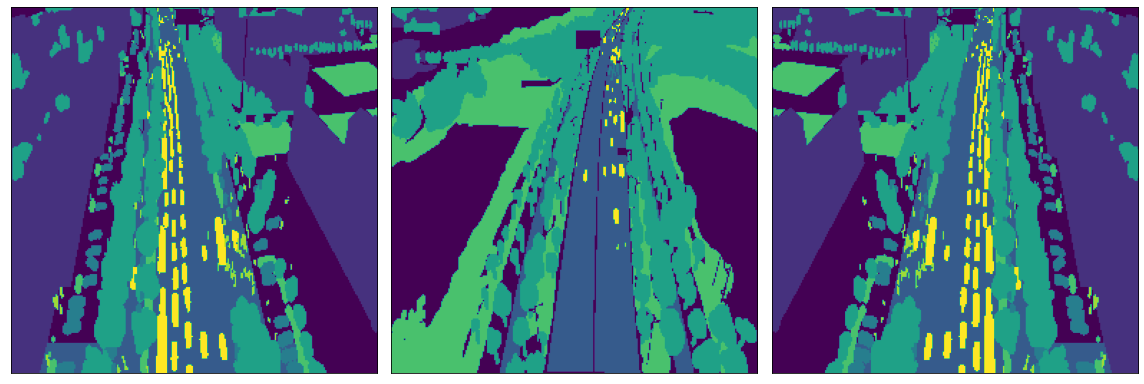

In [11]:
indices = [0, 100, 200]
plot([train_dataset[index][1].squeeze(0).numpy() for index in indices]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


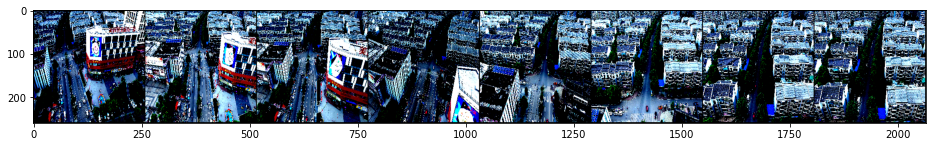

In [12]:
images, _ = next(iter(val_dataloader))
plt.figure(figsize=(16, 8))
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0));

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = UAVIDSemanticSegmentationModel(num_classes=NUM_CLASSES).to(device)

criterion = Loss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training

In [14]:
model.train()

for epoch in range(EPOCHS):
    running_loss = list()

    for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
    
    print(f'epoch: {epoch:2d}, iteration: {i + 1:4d}, loss: {sum(running_loss) / len(running_loss):.4f}')
            
model.eval();

100%|████████████████████████████████████████████████████████████████| 75/75 [00:24<00:00,  3.12it/s]

epoch:  0, iteration:   75, loss: 1.6266



100%|████████████████████████████████████████████████████████████████| 75/75 [00:22<00:00,  3.29it/s]

epoch:  1, iteration:   75, loss: 1.2284



100%|████████████████████████████████████████████████████████████████| 75/75 [00:23<00:00,  3.24it/s]

epoch:  2, iteration:   75, loss: 1.1326



100%|████████████████████████████████████████████████████████████████| 75/75 [00:23<00:00,  3.23it/s]

epoch:  3, iteration:   75, loss: 1.0820



100%|████████████████████████████████████████████████████████████████| 75/75 [00:23<00:00,  3.26it/s]

epoch:  4, iteration:   75, loss: 1.0573



100%|████████████████████████████████████████████████████████████████| 75/75 [00:22<00:00,  3.28it/s]

epoch:  5, iteration:   75, loss: 1.0382



100%|████████████████████████████████████████████████████████████████| 75/75 [00:22<00:00,  3.27it/s]

epoch:  6, iteration:   75, loss: 1.0102



100%|████████████████████████████████████████████████████████████████| 75/75 [00:23<00:00,  3.16it/s]

epoch:  7, iteration:   75, loss: 0.9972


# Saving model

In [15]:
torch.save(model.state_dict(), CHECKPOINT_PATH)

# Loading model

In [16]:
model.load_state_dict(torch.load(CHECKPOINT_PATH))
model.eval();

# Evaluation

In [17]:
evaluate(model, train_dataloader, train=True)

mIOU of the network on the 600 train images: 0.182 %


In [18]:
evaluate(model, val_dataloader, train=False)

mIOU of the network on the 72 test images: 0.177 %


# Visualization

In [19]:
def plot_model_preds(index):
    color_transformer = UAVidColorTransformer()

    with torch.no_grad():
        image, label = val_dataset[index]
        image = image.to(device)
        label = label.to(device)
        outputs = model(image.unsqueeze(0))
        _, outputs = torch.max(outputs, 1)
        outputs = outputs.squeeze(0).cpu().numpy()
        outputs_colored = color_transformer.inverse_transform(outputs)
        image = image.cpu().numpy()
        label = label.cpu().numpy()
        label_colored = color_transformer.inverse_transform(label)

    plot([val_dataset.get_np_image(index), outputs_colored, label_colored]);

In [20]:
ipywidgets.interact(
    plot_model_preds,    
    index=ipywidgets.IntText(min=0, max=len(val_dataset), step=1, value=0));

interactive(children=(IntText(value=0, description='index'), Output()), _dom_classes=('widget-interact',))

# What's next?

In order to boost segmentation accuracy you can:
 - Use State-Of-The-Art model architecture
 - Change Loss function
 - Play with learning_rate of optimizer
 - Increase image resolution
 - Add image augmenations